In [1]:
!pip install gdown
!gdown '1BJ0F9upmZ97NlVK8jW7epb7YUwFDmM13'
!unzip -q ToothNumber_TaskDataset.zip -d /content/dataset/

Downloading...
From (original): https://drive.google.com/uc?id=1BJ0F9upmZ97NlVK8jW7epb7YUwFDmM13
From (redirected): https://drive.google.com/uc?id=1BJ0F9upmZ97NlVK8jW7epb7YUwFDmM13&confirm=t&uuid=ed5c1cd5-b1c9-4a99-9042-afb9c3e0b448
To: /content/ToothNumber_TaskDataset.zip
100% 42.6M/42.6M [00:00<00:00, 222MB/s]


In [2]:
import os
import random
import shutil

# --- Configuration ---
base_dir = '/content/dataset/'
# Ensure original structure exists before running
image_source_dir = os.path.join(base_dir, 'images_original')
label_source_dir = os.path.join(base_dir, 'labels_original')

# (First time only) Rename original folders to avoid conflict
if not os.path.exists(image_source_dir):
    os.rename(os.path.join(base_dir, 'images'), image_source_dir)
    os.rename(os.path.join(base_dir, 'labels'), label_source_dir)


In [3]:

# --- Get a list of all image files ---
all_files = os.listdir(image_source_dir)
random.shuffle(all_files)

# --- Calculate split points ---
train_split = int(len(all_files) * 0.80)
val_split = int(len(all_files) * 0.90) # 80% for train, next 10% for val

train_files = all_files[:train_split]
val_files = all_files[train_split:val_split]
test_files = all_files[val_split:]

# --- Create new directories ---
for folder in ['train/images', 'train/labels', 'val/images', 'val/labels', 'test/images', 'test/labels']:
    os.makedirs(os.path.join(base_dir, folder), exist_ok=True)


In [4]:

# --- Function to move files ---
def move_files(file_list, destination_set):
    for filename in file_list:
        basename = os.path.splitext(filename)[0]
        # Move image
        shutil.copy(os.path.join(image_source_dir, filename), os.path.join(base_dir, destination_set, 'images', filename))
        # Move label
        shutil.copy(os.path.join(label_source_dir, basename + '.txt'), os.path.join(base_dir, destination_set, 'labels', basename + '.txt'))


In [5]:

# --- Move the files ---
move_files(train_files, 'train')
move_files(val_files, 'val')
move_files(test_files, 'test')

print(f"Moved {len(train_files)} files to the training set.")
print(f"Moved {len(val_files)} files to the validation set.")
print(f"Moved {len(test_files)} files to the test set.")

Moved 397 files to the training set.
Moved 50 files to the validation set.
Moved 50 files to the test set.


In [8]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 2.2 MB/s eta 0:00:00


In [10]:
from ultralytics import YOLO

model = YOLO('yolov8s.pt')

results = model.train(
    data='/content/dental_data.yaml',
    epochs=100,
    imgsz=640,
    batch=16,
    name='dental_detection'
)

Ultralytics 8.3.187 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dental_data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=dental_detection, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, p

In [12]:
# Load the trained model
model = YOLO('/content/runs/detect/dental_detection/weights/best.pt')

# Evaluate on the test set
metrics = model.val(split='test')

# The 'metrics' object contains precision, recall, mAP50, mAP50-95, etc.
print(f"mAP50-95: {metrics.box.map}")
print(f"mAP50: {metrics.box.map50}")
print(f"Precision: {metrics.box.p[0]}") # Precision for the first class, check metrics for overall
print(f"Recall: {metrics.box.r[0]}") # Recall for the first class

Ultralytics 8.3.187 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,137,968 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1186.3±922.6 MB/s, size: 72.2 KB)
val: Scanning /content/dataset/test/labels... 50 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 50/50 1831.7it/s 0.0s
val: New cache created: /content/dataset/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 1.2it/s 3.4s
                   all         50       1442       0.85      0.863      0.912      0.663
           Canine (13)         46         46       0.87      0.913      0.929      0.608
           Canine (23)         49         49      0.937      0.915      0.953      0.668
           Canine (33)         50         50      0.877        0.8      0.909      0.613
           Canine (43)         49         50      0.877      0.855      0.875      0.618


image 1/1 /content/dataset/test/images/bce8b3c3-20250408-112055469.jpg: 640x640 1 Canine (13), 1 Canine (23), 1 Canine (33), 1 Central Incisor (21), 1 Central Incisor (41), 2 Central Incisor (31)s, 1 Central Incisor (11), 1 First Molar (16), 1 First Molar (26), 1 First Molar (36), 1 First Molar (46), 1 First Premolar (14), 1 First Premolar (34), 1 First Premolar (24), 2 Lateral Incisor (22)s, 1 Lateral Incisor (32), 1 Lateral Incisor (12), 1 Second Molar (17), 1 Second Molar (27), 1 Second Molar (37), 1 Second Molar (47), 1 Second Premolar (15), 1 Second Premolar (25), 1 Second Premolar (35), 1 Second Premolar (45), 1 Third Molar (18), 1 Third Molar (28), 1 Third Molar (38), 1 Third Molar (48), 16.3ms
Speed: 1.7ms preprocess, 16.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


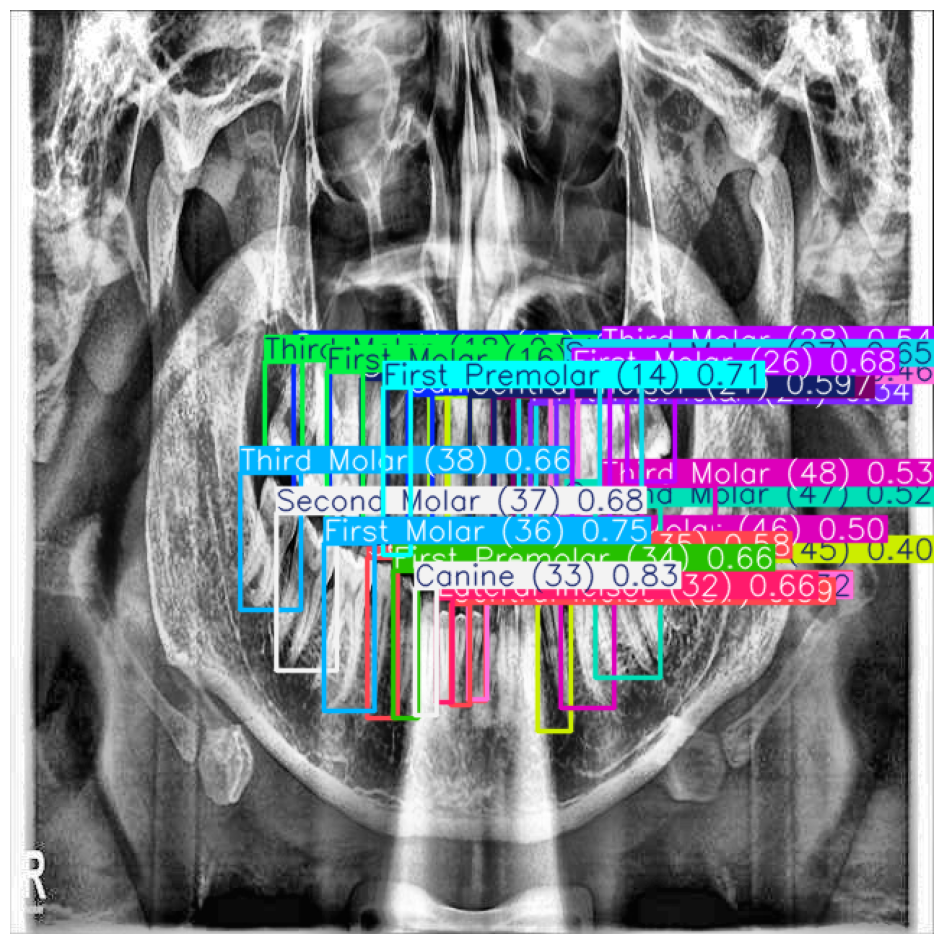


image 1/1 /content/dataset/test/images/cate8-00071_jpg.rf.03da7b65707ea6f08434c6d658b29def.jpg: 640x640 1 Canine (13), 1 Canine (23), 2 Canine (43)s, 1 Central Incisor (21), 2 Central Incisor (41)s, 1 Central Incisor (11), 1 First Molar (16), 1 First Molar (26), 1 First Molar (36), 2 First Molar (46)s, 1 First Premolar (14), 2 First Premolar (44)s, 1 First Premolar (24), 1 Lateral Incisor (22), 2 Lateral Incisor (42)s, 1 Lateral Incisor (12), 1 Second Molar (17), 1 Second Molar (27), 1 Second Molar (37), 2 Second Molar (47)s, 1 Second Premolar (15), 1 Second Premolar (25), 2 Second Premolar (45)s, 1 Third Molar (28), 1 Third Molar (38), 1 Third Molar (48), 24.4ms
Speed: 2.1ms preprocess, 24.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


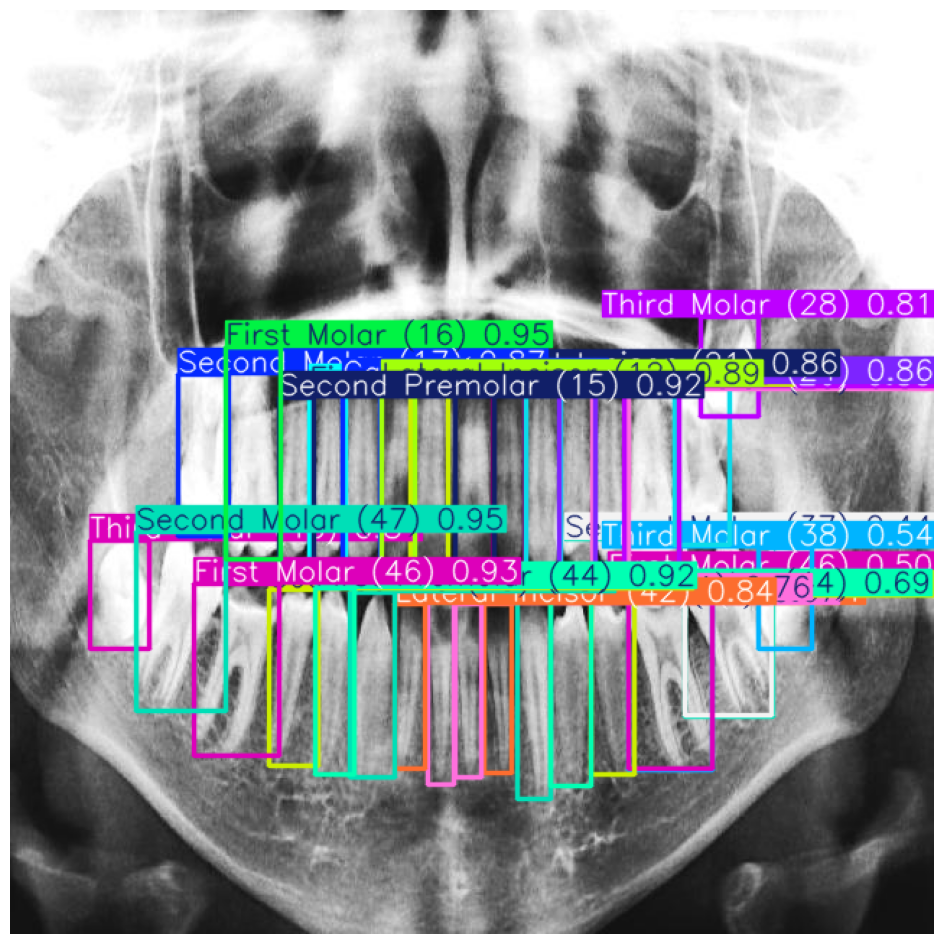


image 1/1 /content/dataset/test/images/cate2-00037_jpg.rf.87058b67873cff49107908294d11ab73.jpg: 640x640 1 Canine (13), 2 Canine (23)s, 1 Canine (33), 1 Canine (43), 1 Central Incisor (21), 1 Central Incisor (41), 1 Central Incisor (31), 2 Central Incisor (11)s, 1 First Molar (16), 2 First Molar (26)s, 1 First Molar (36), 1 First Molar (46), 1 First Premolar (14), 1 First Premolar (34), 1 First Premolar (44), 2 First Premolar (24)s, 2 Lateral Incisor (22)s, 1 Lateral Incisor (32), 1 Lateral Incisor (42), 2 Lateral Incisor (12)s, 2 Second Molar (27)s, 1 Second Molar (37), 1 Second Molar (47), 1 Second Premolar (25), 1 Second Premolar (35), 1 Second Premolar (45), 2 Third Molar (28)s, 1 Third Molar (38), 1 Third Molar (48), 16.4ms
Speed: 2.7ms preprocess, 16.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


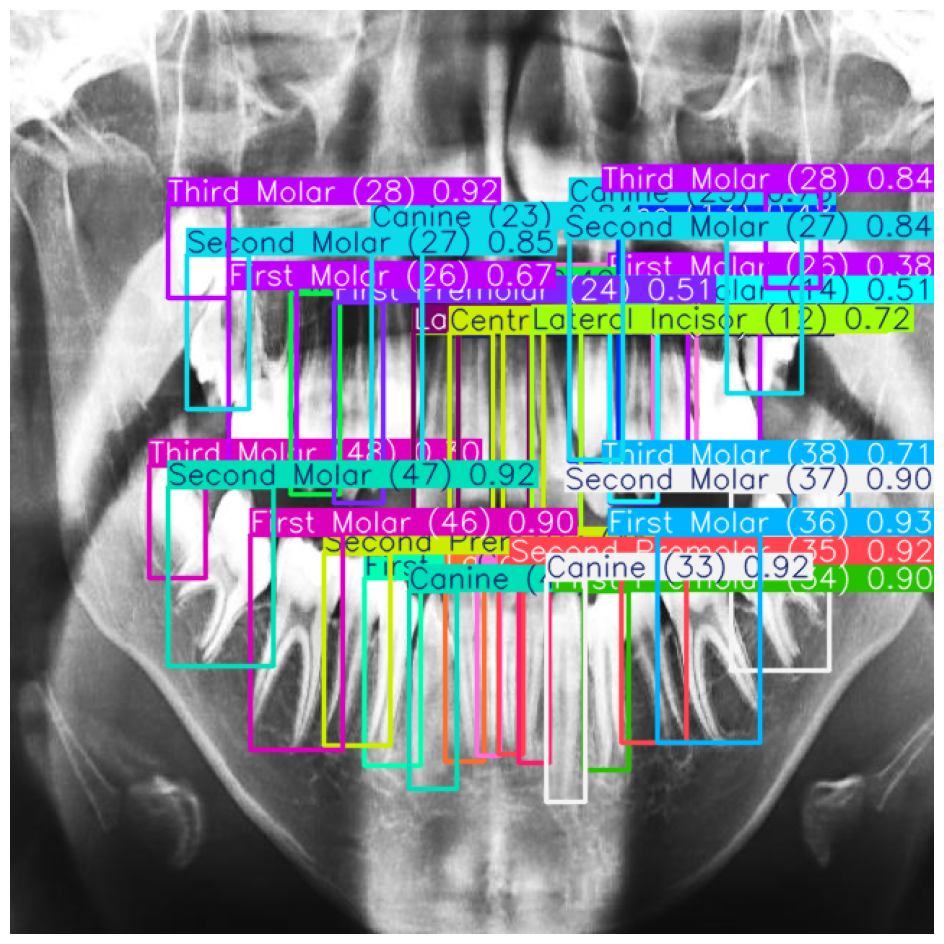

Saved result images to /content/results/


In [15]:
import cv2
import matplotlib.pyplot as plt
import os

# Load your trained model
model = YOLO('/content/runs/detect/dental_detection/weights/best.pt')
# Path to your test images
test_image_dir = '/content/dataset/test/images/'
# Create a directory to save results
os.makedirs('/content/results/', exist_ok=True)

# Get a few test images
test_images = os.listdir(test_image_dir)[:3] # Get the first 3 images for the report

for image_name in test_images:
    image_path = os.path.join(test_image_dir, image_name)
    # Run prediction
    results = model(image_path)

    # Plot results and save the image
    annotated_image = results[0].plot() # .plot() automatically draws boxes and labels

    # Save the annotated image
    save_path = f'/content/results/{image_name}'
    cv2.imwrite(save_path, annotated_image)

    # Display in Colab (optional)
    plt.figure(figsize=(12,12))
    plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

print("Saved result images to /content/results/")

In [23]:
    !zip -r runs.zip runs/

  adding: runs/ (stored 0%)
  adding: runs/detect/ (stored 0%)
  adding: runs/detect/.ipynb_checkpoints/ (stored 0%)
  adding: runs/detect/val/ (stored 0%)
  adding: runs/detect/val/val_batch1_labels.jpg (deflated 6%)
  adding: runs/detect/val/BoxP_curve.png (deflated 11%)
  adding: runs/detect/val/val_batch0_labels.jpg (deflated 6%)
  adding: runs/detect/val/confusion_matrix_normalized.png (deflated 21%)
  adding: runs/detect/val/BoxPR_curve.png (deflated 13%)
  adding: runs/detect/val/val_batch0_pred.jpg (deflated 6%)
  adding: runs/detect/val/confusion_matrix.png (deflated 21%)
  adding: runs/detect/val/val_batch1_pred.jpg (deflated 7%)
  adding: runs/detect/val/val_batch2_labels.jpg (deflated 6%)
  adding: runs/detect/val/BoxF1_curve.png (deflated 11%)
  adding: runs/detect/val/val_batch2_pred.jpg (deflated 6%)
  adding: runs/detect/val/BoxR_curve.png (deflated 11%)
  adding: runs/detect/dental_detection/ (stored 0%)
  adding: runs/detect/dental_detection/val_batch1_labels.jpg (def

In [22]:
    !zip -r dataset.zip dataset/

  adding: dataset/ (stored 0%)
  adding: dataset/images_original/ (stored 0%)
  adding: dataset/images_original/cate8-00305_jpg.rf.8c8278b3305348748e46af2f33e2e538.jpg (deflated 1%)
  adding: dataset/images_original/cate5-00108_jpg.rf.996d16807e3c8734f22dd2e43b6ac2d9.jpg (deflated 1%)
  adding: dataset/images_original/cate8-00257_jpg.rf.2f8f9d5cbd873f542d90bcc57bceae33.jpg (deflated 1%)
  adding: dataset/images_original/cate10-00108_jpg.rf.912ca1f68f0307534ff59a071ed40224.jpg (deflated 0%)
  adding: dataset/images_original/cate2-00038_jpg.rf.b4ef5151bae96f4de7f613fb96b7735e.jpg (deflated 1%)
  adding: dataset/images_original/cate8-00094_jpg.rf.c7c830a886d59fb196ffed83200754d7.jpg (deflated 1%)
  adding: dataset/images_original/4b9ffa7d-20250502-151642682.jpg (deflated 2%)
  adding: dataset/images_original/cate8-00191_jpg.rf.856a6afd259fc24434201fdf1c9b37a0.jpg (deflated 1%)
  adding: dataset/images_original/f1e56772-20250428-124704468.jpg (deflated 2%)
  adding: dataset/images_original

In [21]:
    !zip -r results.zip results/

  adding: results/ (stored 0%)
  adding: results/bce8b3c3-20250408-112055469.jpg (deflated 2%)
  adding: results/cate8-00071_jpg.rf.03da7b65707ea6f08434c6d658b29def.jpg (deflated 3%)
  adding: results/cate2-00037_jpg.rf.87058b67873cff49107908294d11ab73.jpg (deflated 2%)
